In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import warnings
import contextlib
from datetime import datetime
import torch.multiprocessing as mp
import sys
mp.set_start_method('spawn')

In [2]:
from utils.datasets import *
from utils.eval import *
from utils.model import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_names = [
    "resnet50",
    "resnet18", "alexnet", "vgg16",
    "densenet", "inception", "googlenet", 
    "resnext50_32x4d", "wide_resnet50_2"
]

cuda


In [4]:
# freezed model
def get_original_model(net):
    if net == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # models.resnet18(pretrained=True)
    elif net == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # model = models.resnet18(pretrained=True)
    elif net == "alexnet":
        # model = models.alexnet(pretrained=True)
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    elif net == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # model = models.vgg16(pretrained=True)
    elif net == "densenet":
        model = models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)
        # model = models.densenet161(pretrained=True)
    elif net == "inception":
        model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        # model = models.inception_v3(pretrained=True)
    elif net == "googlenet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        # model = models.googlenet(pretrained=True)
    elif net == "resnext50_32x4d":
        model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
        # model = models.resnext50_32x4d(pretrained=True)
    elif net == "wide_resnet50_2":
        model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)
        # model = models.wide_resnet50_2(pretrained=True)
    else:
        raise ValueError("Invalid model name")
    for param in model.parameters():
        param.requires_grad = False
    # Remove the last fully connected layer
    if "inception" in net:
        model.aux_logits=False
        num_ftrs = model.fc.in_features
        model.fc = nn.Identity()
        model.fc = nn.Linear(2048, num_classes)
        model.fc.requires_grad = True
        optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    if "alexnet" in net or "vgg" in net or  "mobilenet_v3_large" in net:
        last_fc_layer = model.classifier[-1]
        num_ftrs = last_fc_layer.in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        model.classifier[-1].requires_grad = True
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif "densenet" in net:
        last_fc_layer = model.classifier
        num_ftrs = last_fc_layer.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        model.classifier.requires_grad = True
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Identity()
        model.fc.requires_grad = True
        model.fc = nn.Linear(num_ftrs, num_classes)
        optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    return model,criterion, optimizer

In [5]:
num_epochs = 30
def train_net(net):
    model, criterion, optimizer = get_original_model(net)
    original_stderr = sys.stderr
    accuracy_list = []
    precision_list = []
    recall_list = []
    confusion_matrix_list = []
    f1_list = []
    tps, tns, fps, fns = [], [], [], []
    current_date = datetime.now().strftime('%Y-%m-%d')
    save_dir = os.path.join("saved_models/tl+rotation", current_date)
    os.makedirs(save_dir, exist_ok=True)
    test_ratio=0.3
    
    sys.stderr = open(os.devnull, 'w')
    
    for timestamp in range(1, 290):
    # for timestamp in [150, 160, 170]:
        debug = True
        if timestamp in  [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]:
            debug = True
        if debug:
            print("timestamp: ", timestamp)
        if "inception" in net:
            dataloaders = get_dataloaders(timestamp, test_ratio=test_ratio, inception=True, data_enrich=True)
        else:
            dataloaders = get_dataloaders(timestamp, test_ratio=test_ratio, data_enrich=True)
        model_trained, loss_values = train_model(model, criterion, optimizer, dataloaders, num_epochs=num_epochs, inception=("inception" in net), output=debug, debug=False)
        model_filename = os.path.join(save_dir, f"model_{net}_time_{timestamp}_epochs{num_epochs}.pt")
        torch.save(model_trained.state_dict(), model_filename)
    
        accuracy, precision, recall, f1, tp, tn, fp, fn, confusion_matrix = get_metrics(model_trained, dataloaders['test'], inception=("inception" in net))
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        if debug:
            print("Accuracy: ", accuracy)
        recall_list.append(recall)
        f1_list.append(f1)
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        confusion_matrix_list.append(confusion_matrix)
    sys.stderr = original_stderr
    return accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list

In [6]:
def add_dicts(dict1, dict2):
    result_dict = {}
    for key in dict1.keys():
        result_dict[key] = dict1[key] + dict2[key]
    return result_dict
    
def write_result(model_name, accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list):
    avg_acc = sum(accuracy_list) / len(accuracy_list)
    avg_pre = sum(precision_list) / len(precision_list)
    avg_rec = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    output_folder = f"./output/tl+rotation/{current_date}/{model_name}"
    output_file = f"metrics_{model_name}.txt"
    class_labels = ["BMP4", "CHIR", "DS", "DS+CHIR",  "WT"]

    
    with open(os.path.join(output_folder, output_file), "w") as f:
        f.write("Average Accuracy: " + str(avg_acc) + "\n")
        f.write("Average Precision: " + str(avg_pre) + "\n")
        f.write("Average Recall: " + str(avg_rec) + "\n")
        f.write("Average F1 Score: " + str(avg_f1) + "\n")
        f.write("Accuracy: " + str(accuracy_list) + "\n")
        f.write("Precision: " + str(precision_list) + "\n")
        f.write("Recall: " + str(recall_list) + "\n")
        f.write("F1 Score: " + str(f1_list) + "\n")
        f.write("TPs: " + str(tps) + "\n")
        f.write("TNs: " + str(tns) + "\n")
        f.write("FPs: " + str(fps) + "\n")
        f.write("FNs: " + str(fns) + "\n")

        # Write misclassified pairs
        f.write("Misclassified Pairs:\n")
        mis_total_map = {}
        
        for m in range(len(fps)):
          
            mis_map = {}
            if m+1 in [1, 40, 80, 120, 160, 200, 240, 280, 289]:
                f.write(f"Misclassified Pairs for time {m+1}: ")
            for i in range(len(class_labels)):
                for j in range(i+1, len(class_labels)):
                    pair = f"{class_labels[i]} vs. {class_labels[j]}"
                    if pair not in mis_total_map:
                        mis_total_map[pair] = 0
                    if pair not in mis_map:
                        mis_map[pair] = 0
                    mis_map[f"{class_labels[i]} vs. {class_labels[j]}"] += confusion_matrix_list[m][i][j] + confusion_matrix_list[m][j][i]
                    mis_total_map[f"{class_labels[i]} vs. {class_labels[j]}"] += confusion_matrix_list[m][i][j] + confusion_matrix_list[m][j][i]
            if m+1 in [1, 40, 80, 120, 160, 200, 240, 280, 289]:
                for key, val in mis_map.items():
                    f.write(f"{key}: {val} ")  
                f.write("\n")
        # for key, val in mis_total_map.items():
        f.write(str(mis_total_map) + "\n")
    return mis_total_map

training wide_resnet50_2...
timestamp:  1
Training complete in 0m 35s
Best val Acc: 0.872340
Best val loss: 0.519472
Accuracy:  0.8297872340425532
timestamp:  2
Training complete in 0m 37s
Best val Acc: 0.914894
Best val loss: 0.405398
Accuracy:  0.7446808510638298
timestamp:  3
Training complete in 0m 46s
Best val Acc: 0.914894
Best val loss: 0.359897
Accuracy:  0.851063829787234
timestamp:  4
Training complete in 0m 43s
Best val Acc: 0.978723
Best val loss: 0.254473
Accuracy:  0.8936170212765957
timestamp:  5
Training complete in 0m 36s
Best val Acc: 0.936170
Best val loss: 0.343422
Accuracy:  0.8085106382978723
timestamp:  6
Training complete in 0m 54s
Best val Acc: 0.936170
Best val loss: 0.223223
Accuracy:  0.851063829787234
timestamp:  7
Training complete in 0m 49s
Best val Acc: 0.957447
Best val loss: 0.264604
Accuracy:  0.8085106382978723
timestamp:  8
Training complete in 0m 40s
Best val Acc: 0.936170
Best val loss: 0.332843
Accuracy:  0.8085106382978723
timestamp:  9
Training

<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

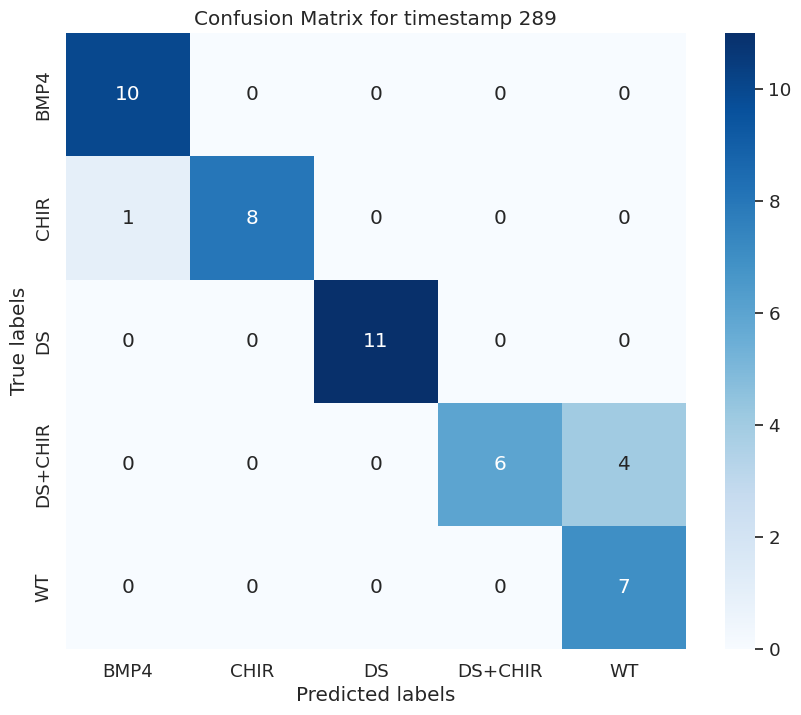

In [7]:
# for model in 
# accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns = train_net("googlenet")
model_names = [
    # "resnet50",
    # "resnet18", 
    # "alexnet", 
    # "vgg16",
    # "densenet", 
    # "inception", 
    # "googlenet", 
    # "resnext50_32x4d", 
    "wide_resnet50_2"
]
acc_map = {}
pre_map = {}
rec_map = {}
f1_map = {}
tps_map = {}
tns_map = {}
fps_map = {}
fns_map = {}
test_ratio=0.3
mis_total_map = {}
for model_name in model_names:
    print(f"training {model_name}...")
    current_date = datetime.now().strftime('%Y-%m-%d')
    os.makedirs(f"./output/tl+rotation/{current_date}/{model_name}", exist_ok=True)
    show_ = False
    accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list = train_net(model_name)
    plot_metric(accuracy_list, 'Accuracy', model=model_name, save=True, show=show_, output=f"output/tl+rotation/{current_date}", num_epochs=num_epochs, test_ratio=test_ratio)
    plot_metric(precision_list, 'Precision', model=model_name, save=True, show=show_,output=f"output/tl+rotation/{current_date}", num_epochs=num_epochs, test_ratio=test_ratio)
    plot_metric(recall_list, 'Recall', model=model_name, save=True, show=show_,output=f"output/tl+rotation/{current_date}", num_epochs=num_epochs, test_ratio=test_ratio)
    plot_metric(f1_list, 'F1 Score', model=model_name, save=True, show=show_,output=f"output/tl+rotation/{current_date}", num_epochs=num_epochs, test_ratio=test_ratio)
    for time in [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]:
    # for time in [1]:
        plot_confusion_matrix(confusion_matrix_list, time, save=True, show=show_,output=f"./output/tl+rotation/{current_date}/{model_name}")
    # acc_map[model_name] = accuracy_list
    # pre_map[model_name] = precision_list
    # rec_map[model_name] = recall_list
    # f1_map[model_name] = f1_list
    # tps_map[model_name] = tps
    # tns_map[model_name] = tns
    # fps_map[model_name] = fps
    # fns_map[model_name] = fns

    print(f"{model_name} average accuracy:", sum(accuracy_list) / len(accuracy_list))

    mis_map = write_result(model_name, accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list)
    if not mis_total_map:
        mis_total_map = mis_map
    else:
        mis_total_map  = add_dicts(mis_total_map, mis_map)
    # print(f"{model_name} misclassified map: {mis_map}")
    print(f"total map: {mis_total_map}")

In [ ]:
# for timestamp in range(1, 2):
# # for timestamp in range(1, 10):
#     print("timestamp: ", timestamp)
#     dataloaders = get_dataloaders(timestamp, data_enrich=True)

#     print(len(dataloaders['train'].dataset))
#     print(len(dataloaders['val'].dataset))
#     print(len(dataloaders['test'].dataset))